# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. 
The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based in the setting of reinforcement learning.
Reinforcment learning is an area of machine learning concerned with how agents take actions in an environment in order to maximize the sum of rewards.
So what a GAIL agent does is take actions in the bark environment and measure the resulting state of the agent and the world.

As the name says we are more specifically located in the setting of Imitation Learning. 
Our agent will try to learn a policy that mimics demonstrations.
We extract these demonstrations as Expert Trajectories from the interaction dataset by replaying the dataset in the bark simulator.
This gives us the expert rollouts which are a set of state action pairs representing the expert knowledge. 
In a RL setting, we need some sort of reward to update the agents network parameters.

In the GAIL approach we get the reward from an adversarial game:
Another discriminator network gets fed the agent rollouts and the experts rollouts and wants to classify between them accurately.
The agent network wants to fool the discriminator by minimizing the probability to get classified as fake.
The classification as fake or not that is output by the discriminator is the reward we feed into our agent network.
To minimize the classification as fake the agent network needs to mimic the experts demonstration and by doing so learn the experts policy.


<img width=70% src="files/data/gail_overview.gif">

## Project task

The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

### Port GAIL driver to bark
Do not reimplement gail, but use an existing implementation and bring it to bark.
We chose [TF2RL](https://github.com/keiohta/tf2rl).

### Train the GAIL agent on the Interaction Dataset
As a data source, we will use the interaction dataset: https://arxiv.org/abs/1910.03088 . Here,
w e are interested in the merging scenes: deu_merging_mt and chn_merging_zs
Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-
simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (NOte that
the dataset itsself is NOT enclosed with bark due to license limitations).
Train + validate agents individually for each scenes: In the first step, replace one agent and use
all other agents from the dataset: The gail agent navigates safely. Afterwards, replace more

### Evaluate the agent
Exchange the trained models on the German and the Chinese map: how well is the
generalization?
ONLY place gail agents on the map: Can we generate scenes that "look alike" the real scenarios?

## Interaction Dataset

## Expert Trajectories

## Generate Expert Trajectories

In [1]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["TrackIds"] = [
    63, 64, 65, 66, 67, 68]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["StartTs"] = 232000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EndTs"] = 259000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EgoTrackId"] = ego_agent

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


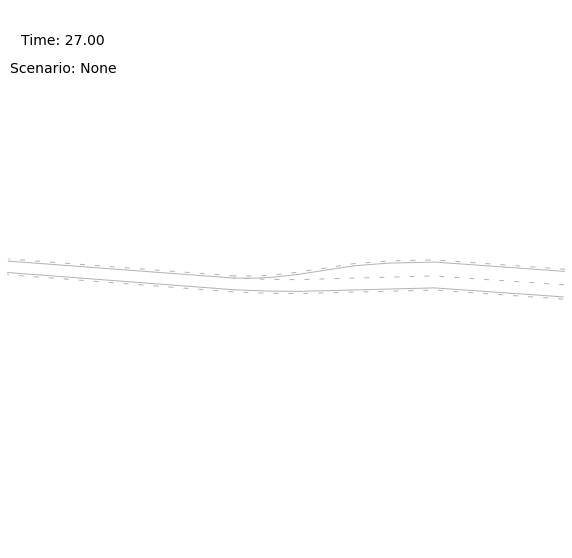

In [2]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

### The simulation gives us a number of observations and actions for the experts:

In [3]:
# Small number of observations for our agent
print(f'Observations for the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['obs'][:5])

Observations for the agent 66

[array([0.54990917, 0.55034685, 0.49115214, 0.02195392, 0.54979807,
       0.55021369, 0.48701411, 0.01664484, 0.55023372, 0.55031705,
       0.48717329, 0.01795783, 0.55020285, 0.55017918, 0.48908314,
       0.01927594]),
 array([0.5498873 , 0.5503481 , 0.49115214, 0.02188459, 0.54978162,
       0.55021507, 0.48701411, 0.0162844 , 0.5502159 , 0.55031848,
       0.48733243, 0.01776604, 0.55018389, 0.55018038, 0.48940146,
       0.0182608 ]),
 array([0.54986548, 0.55034935, 0.49099299, 0.02179474, 0.54976547,
       0.55021638, 0.48685497, 0.01594391, 0.55019826, 0.55031985,
       0.48733243, 0.01757585, 0.55016589, 0.55018145, 0.4895606 ,
       0.0172271 ]),
 array([0.54984373, 0.55035061, 0.49099299, 0.02165496, 0.54974967,
       0.55021775, 0.48685497, 0.01561338, 0.55018073, 0.55032122,
       0.48733243, 0.01744546, 0.55014902, 0.55018252, 0.48971975,
       0.01617412]),
 array([0.54982221, 0.55035186, 0.49083385, 0.02145529, 0.54973418,
       0.

In [4]:
# Small number of actions for our agent
print(f'Actions of the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['act'][:5])

Actions of the agent 66

[[0.0, -0.0003466568835577833],
 [-0.004201827340902073, -0.00030657489373432596],
 [0.002051691485158719, -0.00035168134700955115],
 [-0.004200119214675828, -0.0005815505374677107],
 [0.002049979741333098, -0.0009188447324507322]]


## GAIL implementation

### TF2RL implementation
We have chosen an off the shelf implementation, thelibrary [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement algorithms and training methods in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with the actor and critic networks. Both of them has 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect the agent is not in the traditional GAIL setup with 2 neural networks, but instead it actually has 5 networks, since the DDPG agent it self has got 4 of them for greater stability during training. The DDPG agent's critic network basically receives the judgement of the Discriminator network as the reward from the environment and its training aims to maximize this reward.

### Integration into BARK
The integration of the TF2RL based GAIL agent is done along existing BARK concepts and has been done in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of tf2rl about the environment. The observation and action normalization also takes place here.
    * file: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * file: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * file: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * file: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * file: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is shown. Later the performance of a pre-trained agent can be visualized.

---

### Training
The parameters which can be set on demand:
* The number of steps to train for.
* The frequency of testing during training
* The number of episodes in each testing round.

In [1]:
# Costumise some parameters here!!! #

max_steps = 100000          # Number of steps to train for.
test_interval = 1000       # test in every ... steps.
test_episodes = 5          # number of test episodes.
gpu = 0                    # use -1 for cpu only.

In [6]:
# IMPORTS
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint, GailMergingBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories

# Load the TensorBoard notebook extension
%load_ext tensorboard

The next cell deletes the previous logs and launches tensorboard. After tensorboard has launced, please go on to the next cell and start the training. The tensorboard window refreshes it self in every 30 secs, but you can also refresh it by hand in the top right corner.

In [17]:
# launching tensorboard and deleting the previous runs logdirs:
%rm -r "data/logs"
%mkdir "data/logs"
%tensorboard --logdir "data/logs"

/home/ferenc/.cache/bazel/_bazel_ferenc/d27c94d45ef586b197c709d8101d6384/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/commons/xodr_parser.py:108: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):
15:27:48.488 [INFO] (trainer.py:65) Restored None
15:27:48.735 [INFO] (irl_trainer.py:74) Total Epi:     1 Steps:       7 Episode Steps:     7 Return: -1.0000 FPS: 28.56
15:27:48.758 [INFO] (irl_trainer.py:74) Total Epi:     2 Steps:      20 Episode Steps:    13 Return: -1.0000 FPS: 646.89
15:27:48.770 [INFO] (irl_trainer.py:74) Total Epi:     3 Steps:      25 Episode Steps:     5 Return: -1.0000 FPS: 457.97
15:27:48.780 [INFO] (irl_trainer.py:74) Total Epi:     4 Steps:      27 Episode Steps:     2 Return: -1.0000 FPS: 340.49
15:27:48.796 [INFO] (irl_trainer.py:74) Total Epi:     5 Steps:      33 Episode Steps:     6 Return: -1.000

15:27:49.836 [INFO] (irl_trainer.py:74) Total Epi:    66 Steps:     528 Episode Steps:     4 Return: -1.0000 FPS: 506.36
15:27:49.851 [INFO] (irl_trainer.py:74) Total Epi:    67 Steps:     535 Episode Steps:     7 Return: -1.0000 FPS: 581.33
15:27:49.860 [INFO] (irl_trainer.py:74) Total Epi:    68 Steps:     540 Episode Steps:     5 Return: -1.0000 FPS: 592.87
15:27:49.871 [INFO] (irl_trainer.py:74) Total Epi:    69 Steps:     546 Episode Steps:     6 Return: -1.0000 FPS: 629.42
15:27:49.879 [INFO] (irl_trainer.py:74) Total Epi:    70 Steps:     549 Episode Steps:     3 Return: -1.0000 FPS: 484.13
15:27:49.888 [INFO] (irl_trainer.py:74) Total Epi:    71 Steps:     553 Episode Steps:     4 Return: -1.0000 FPS: 540.25
15:27:49.900 [INFO] (irl_trainer.py:74) Total Epi:    72 Steps:     560 Episode Steps:     7 Return: -1.0000 FPS: 644.90
15:27:49.908 [INFO] (irl_trainer.py:74) Total Epi:    73 Steps:     563 Episode Steps:     3 Return: -1.0000 FPS: 490.86
15:27:49.918 [INFO] (irl_trainer

15:27:54.140 [INFO] (irl_trainer.py:74) Total Epi:   133 Steps:    1138 Episode Steps:     4 Return: -1.0000 FPS: 65.46
15:27:54.206 [INFO] (irl_trainer.py:74) Total Epi:   134 Steps:    1142 Episode Steps:     4 Return: -1.0000 FPS: 61.76
15:27:54.260 [INFO] (irl_trainer.py:74) Total Epi:   135 Steps:    1145 Episode Steps:     3 Return: -1.0000 FPS: 57.60
15:27:54.313 [INFO] (irl_trainer.py:74) Total Epi:   136 Steps:    1148 Episode Steps:     3 Return: -1.0000 FPS: 58.43
15:27:54.471 [INFO] (irl_trainer.py:74) Total Epi:   137 Steps:    1158 Episode Steps:    10 Return: -1.0000 FPS: 63.69
15:27:54.586 [INFO] (irl_trainer.py:74) Total Epi:   138 Steps:    1165 Episode Steps:     7 Return: -1.0000 FPS: 62.51
15:27:54.640 [INFO] (irl_trainer.py:74) Total Epi:   139 Steps:    1168 Episode Steps:     3 Return: -1.0000 FPS: 57.12
15:27:54.691 [INFO] (irl_trainer.py:74) Total Epi:   140 Steps:    1171 Episode Steps:     3 Return: -1.0000 FPS: 60.78
15:27:54.743 [INFO] (irl_trainer.py:74) 

15:28:04.083 [INFO] (irl_trainer.py:74) Total Epi:   202 Steps:    1708 Episode Steps:    15 Return: -1.0000 FPS: 63.96
15:28:04.252 [INFO] (irl_trainer.py:74) Total Epi:   203 Steps:    1718 Episode Steps:    10 Return: -1.0000 FPS: 59.93
15:28:04.362 [INFO] (irl_trainer.py:74) Total Epi:   204 Steps:    1725 Episode Steps:     7 Return: -1.0000 FPS: 64.46
15:28:04.591 [INFO] (irl_trainer.py:74) Total Epi:   205 Steps:    1740 Episode Steps:    15 Return: -1.0000 FPS: 65.80
15:28:04.735 [INFO] (irl_trainer.py:74) Total Epi:   206 Steps:    1749 Episode Steps:     9 Return: -1.0000 FPS: 63.38
15:28:04.921 [INFO] (irl_trainer.py:74) Total Epi:   207 Steps:    1761 Episode Steps:    12 Return: -1.0000 FPS: 64.99
15:28:05.088 [INFO] (irl_trainer.py:74) Total Epi:   208 Steps:    1772 Episode Steps:    11 Return: -1.0000 FPS: 66.33
15:28:05.291 [INFO] (irl_trainer.py:74) Total Epi:   209 Steps:    1784 Episode Steps:    12 Return: -1.0000 FPS: 59.67
15:28:05.398 [INFO] (irl_trainer.py:74) 

15:28:15.959 [INFO] (irl_trainer.py:74) Total Epi:   270 Steps:    2416 Episode Steps:    13 Return: -1.0000 FPS: 63.58
15:28:16.144 [INFO] (irl_trainer.py:74) Total Epi:   271 Steps:    2428 Episode Steps:    12 Return: -1.0000 FPS: 65.29
15:28:16.374 [INFO] (irl_trainer.py:74) Total Epi:   272 Steps:    2443 Episode Steps:    15 Return: -1.0000 FPS: 65.89
15:28:16.461 [INFO] (irl_trainer.py:74) Total Epi:   273 Steps:    2448 Episode Steps:     5 Return: -1.0000 FPS: 58.51
15:28:16.666 [INFO] (irl_trainer.py:74) Total Epi:   274 Steps:    2461 Episode Steps:    13 Return: -1.0000 FPS: 63.92
15:28:16.826 [INFO] (irl_trainer.py:74) Total Epi:   275 Steps:    2471 Episode Steps:    10 Return: -1.0000 FPS: 62.79
15:28:16.977 [INFO] (irl_trainer.py:74) Total Epi:   276 Steps:    2480 Episode Steps:     9 Return: -1.0000 FPS: 60.66
15:28:17.227 [INFO] (irl_trainer.py:74) Total Epi:   277 Steps:    2496 Episode Steps:    16 Return: -1.0000 FPS: 64.28
15:28:17.408 [INFO] (irl_trainer.py:74) 

15:28:26.939 [INFO] (irl_trainer.py:74) Total Epi:   338 Steps:    3074 Episode Steps:    11 Return: -1.0000 FPS: 64.85
15:28:27.026 [INFO] (irl_trainer.py:74) Total Epi:   339 Steps:    3079 Episode Steps:     5 Return: -1.0000 FPS: 58.15
15:28:27.112 [INFO] (irl_trainer.py:74) Total Epi:   340 Steps:    3084 Episode Steps:     5 Return: -1.0000 FPS: 59.81
15:28:27.305 [INFO] (irl_trainer.py:74) Total Epi:   341 Steps:    3096 Episode Steps:    12 Return: -1.0000 FPS: 62.57
15:28:27.458 [INFO] (irl_trainer.py:74) Total Epi:   342 Steps:    3106 Episode Steps:    10 Return: -1.0000 FPS: 65.99
15:28:27.626 [INFO] (irl_trainer.py:74) Total Epi:   343 Steps:    3117 Episode Steps:    11 Return: -1.0000 FPS: 66.02
15:28:27.829 [INFO] (irl_trainer.py:74) Total Epi:   344 Steps:    3130 Episode Steps:    13 Return: -1.0000 FPS: 64.39
15:28:27.986 [INFO] (irl_trainer.py:74) Total Epi:   345 Steps:    3140 Episode Steps:    10 Return: -1.0000 FPS: 64.19
15:28:28.130 [INFO] (irl_trainer.py:74) 

15:28:37.759 [INFO] (irl_trainer.py:74) Total Epi:   407 Steps:    3742 Episode Steps:    15 Return: -1.0000 FPS: 53.73
15:28:37.861 [INFO] (irl_trainer.py:74) Total Epi:   408 Steps:    3748 Episode Steps:     6 Return: -1.0000 FPS: 59.98
15:28:37.969 [INFO] (irl_trainer.py:74) Total Epi:   409 Steps:    3755 Episode Steps:     7 Return: -1.0000 FPS: 65.95
15:28:38.148 [INFO] (irl_trainer.py:74) Total Epi:   410 Steps:    3766 Episode Steps:    11 Return: -1.0000 FPS: 61.73
15:28:38.356 [INFO] (irl_trainer.py:74) Total Epi:   411 Steps:    3779 Episode Steps:    13 Return: -1.0000 FPS: 63.12
15:28:38.554 [INFO] (irl_trainer.py:74) Total Epi:   412 Steps:    3791 Episode Steps:    12 Return: -1.0000 FPS: 61.25
15:28:38.758 [INFO] (irl_trainer.py:74) Total Epi:   413 Steps:    3804 Episode Steps:    13 Return:  1.0000 FPS: 64.02
15:28:38.965 [INFO] (irl_trainer.py:74) Total Epi:   414 Steps:    3817 Episode Steps:    13 Return: -1.0000 FPS: 63.27
15:28:39.192 [INFO] (irl_trainer.py:74) 

15:28:48.959 [INFO] (irl_trainer.py:74) Total Epi:   475 Steps:    4426 Episode Steps:     5 Return: -1.0000 FPS: 54.34
15:28:49.201 [INFO] (irl_trainer.py:74) Total Epi:   476 Steps:    4440 Episode Steps:    14 Return: -1.0000 FPS: 58.39
15:28:49.283 [INFO] (irl_trainer.py:74) Total Epi:   477 Steps:    4445 Episode Steps:     5 Return: -1.0000 FPS: 61.82
15:28:49.455 [INFO] (irl_trainer.py:74) Total Epi:   478 Steps:    4456 Episode Steps:    11 Return: -1.0000 FPS: 64.41
15:28:49.741 [INFO] (irl_trainer.py:74) Total Epi:   479 Steps:    4474 Episode Steps:    18 Return:  1.0000 FPS: 63.28
15:28:50.000 [INFO] (irl_trainer.py:74) Total Epi:   480 Steps:    4491 Episode Steps:    17 Return: -1.0000 FPS: 65.91
15:28:50.180 [INFO] (irl_trainer.py:74) Total Epi:   481 Steps:    4502 Episode Steps:    11 Return: -1.0000 FPS: 61.73
15:28:50.374 [INFO] (irl_trainer.py:74) Total Epi:   482 Steps:    4514 Episode Steps:    12 Return:  1.0000 FPS: 62.26
15:28:50.559 [INFO] (irl_trainer.py:74) 

15:29:01.766 [INFO] (irl_trainer.py:74) Total Epi:   543 Steps:    5223 Episode Steps:     5 Return: -1.0000 FPS: 60.74
15:29:01.972 [INFO] (irl_trainer.py:74) Total Epi:   544 Steps:    5236 Episode Steps:    13 Return:  1.0000 FPS: 63.54
15:29:02.167 [INFO] (irl_trainer.py:74) Total Epi:   545 Steps:    5248 Episode Steps:    12 Return:  1.0000 FPS: 62.08
15:29:02.248 [INFO] (irl_trainer.py:74) Total Epi:   546 Steps:    5253 Episode Steps:     5 Return: -1.0000 FPS: 62.37
15:29:02.418 [INFO] (irl_trainer.py:74) Total Epi:   547 Steps:    5263 Episode Steps:    10 Return:  1.0000 FPS: 59.43
15:29:02.837 [INFO] (irl_trainer.py:74) Total Epi:   548 Steps:    5290 Episode Steps:    27 Return: -1.0000 FPS: 64.61
15:29:02.921 [INFO] (irl_trainer.py:74) Total Epi:   549 Steps:    5295 Episode Steps:     5 Return: -1.0000 FPS: 61.02
15:29:03.154 [INFO] (irl_trainer.py:74) Total Epi:   550 Steps:    5310 Episode Steps:    15 Return:  1.0000 FPS: 64.65
15:29:03.284 [INFO] (irl_trainer.py:74) 

15:29:14.928 [INFO] (irl_trainer.py:74) Total Epi:   611 Steps:    6028 Episode Steps:    14 Return: -1.0000 FPS: 62.44
15:29:15.342 [INFO] (irl_trainer.py:74) Total Epi:   612 Steps:    6054 Episode Steps:    26 Return:  1.0000 FPS: 63.01
15:29:15.703 [INFO] (irl_trainer.py:74) Total Epi:   613 Steps:    6077 Episode Steps:    23 Return:  1.0000 FPS: 63.91
15:29:15.769 [INFO] (irl_trainer.py:74) Total Epi:   614 Steps:    6081 Episode Steps:     4 Return: -1.0000 FPS: 62.48
15:29:16.000 [INFO] (irl_trainer.py:74) Total Epi:   615 Steps:    6096 Episode Steps:    15 Return:  1.0000 FPS: 65.23
15:29:16.084 [INFO] (irl_trainer.py:74) Total Epi:   616 Steps:    6101 Episode Steps:     5 Return: -1.0000 FPS: 60.60
15:29:16.153 [INFO] (irl_trainer.py:74) Total Epi:   617 Steps:    6105 Episode Steps:     4 Return: -1.0000 FPS: 59.66
15:29:16.207 [INFO] (irl_trainer.py:74) Total Epi:   618 Steps:    6108 Episode Steps:     3 Return: -1.0000 FPS: 57.40
15:29:16.434 [INFO] (irl_trainer.py:74) 

15:29:27.300 [INFO] (irl_trainer.py:74) Total Epi:   680 Steps:    6798 Episode Steps:     4 Return: -1.0000 FPS: 58.72
15:29:27.454 [INFO] (irl_trainer.py:74) Total Epi:   681 Steps:    6808 Episode Steps:    10 Return:  1.0000 FPS: 65.60
15:29:27.605 [INFO] (irl_trainer.py:74) Total Epi:   682 Steps:    6817 Episode Steps:     9 Return:  1.0000 FPS: 60.04
15:29:27.671 [INFO] (irl_trainer.py:74) Total Epi:   683 Steps:    6821 Episode Steps:     4 Return: -1.0000 FPS: 62.69
15:29:27.925 [INFO] (irl_trainer.py:74) Total Epi:   684 Steps:    6837 Episode Steps:    16 Return:  1.0000 FPS: 63.53
15:29:28.013 [INFO] (irl_trainer.py:74) Total Epi:   685 Steps:    6842 Episode Steps:     5 Return: -1.0000 FPS: 57.84
15:29:28.241 [INFO] (irl_trainer.py:74) Total Epi:   686 Steps:    6856 Episode Steps:    14 Return: -1.0000 FPS: 61.74
15:29:28.311 [INFO] (irl_trainer.py:74) Total Epi:   687 Steps:    6860 Episode Steps:     4 Return: -1.0000 FPS: 58.17
15:29:28.429 [INFO] (irl_trainer.py:74) 

15:29:37.868 [INFO] (irl_trainer.py:74) Total Epi:   748 Steps:    7445 Episode Steps:     5 Return: -1.0000 FPS: 56.30
15:29:38.074 [INFO] (irl_trainer.py:74) Total Epi:   749 Steps:    7458 Episode Steps:    13 Return:  1.0000 FPS: 63.67
15:29:38.242 [INFO] (irl_trainer.py:74) Total Epi:   750 Steps:    7469 Episode Steps:    11 Return: -1.0000 FPS: 66.06
15:29:38.409 [INFO] (irl_trainer.py:74) Total Epi:   751 Steps:    7479 Episode Steps:    10 Return:  1.0000 FPS: 60.41
15:29:38.479 [INFO] (irl_trainer.py:74) Total Epi:   752 Steps:    7483 Episode Steps:     4 Return: -1.0000 FPS: 58.82
15:29:38.699 [INFO] (irl_trainer.py:74) Total Epi:   753 Steps:    7497 Episode Steps:    14 Return:  1.0000 FPS: 64.05
15:29:38.800 [INFO] (irl_trainer.py:74) Total Epi:   754 Steps:    7503 Episode Steps:     6 Return: -1.0000 FPS: 60.33
15:29:38.883 [INFO] (irl_trainer.py:74) Total Epi:   755 Steps:    7508 Episode Steps:     5 Return: -1.0000 FPS: 61.55
15:29:38.954 [INFO] (irl_trainer.py:74) 

15:29:48.684 [INFO] (irl_trainer.py:74) Total Epi:   816 Steps:    8102 Episode Steps:     8 Return: -1.0000 FPS: 59.44
15:29:48.816 [INFO] (irl_trainer.py:74) Total Epi:   817 Steps:    8110 Episode Steps:     8 Return: -1.0000 FPS: 61.15
15:29:48.899 [INFO] (irl_trainer.py:74) Total Epi:   818 Steps:    8115 Episode Steps:     5 Return: -1.0000 FPS: 61.90
15:29:49.150 [INFO] (irl_trainer.py:74) Total Epi:   819 Steps:    8131 Episode Steps:    16 Return:  1.0000 FPS: 63.98
15:29:49.220 [INFO] (irl_trainer.py:74) Total Epi:   820 Steps:    8135 Episode Steps:     4 Return: -1.0000 FPS: 58.17
15:29:49.374 [INFO] (irl_trainer.py:74) Total Epi:   821 Steps:    8144 Episode Steps:     9 Return:  1.0000 FPS: 59.41
15:29:49.610 [INFO] (irl_trainer.py:74) Total Epi:   822 Steps:    8159 Episode Steps:    15 Return:  1.0000 FPS: 63.76
15:29:49.843 [INFO] (irl_trainer.py:74) Total Epi:   823 Steps:    8173 Episode Steps:    14 Return:  1.0000 FPS: 60.63
15:29:49.927 [INFO] (irl_trainer.py:74) 

15:29:59.289 [INFO] (irl_trainer.py:74) Total Epi:   885 Steps:    8752 Episode Steps:     4 Return: -1.0000 FPS: 57.02
15:29:59.509 [INFO] (irl_trainer.py:74) Total Epi:   886 Steps:    8766 Episode Steps:    14 Return:  1.0000 FPS: 63.96
15:29:59.750 [INFO] (irl_trainer.py:74) Total Epi:   887 Steps:    8782 Episode Steps:    16 Return:  1.0000 FPS: 66.75
15:30:00.058 [INFO] (irl_trainer.py:74) Total Epi:   888 Steps:    8801 Episode Steps:    19 Return:  1.0000 FPS: 62.02
15:30:00.331 [INFO] (irl_trainer.py:74) Total Epi:   889 Steps:    8818 Episode Steps:    17 Return:  1.0000 FPS: 62.72
15:30:00.583 [INFO] (irl_trainer.py:74) Total Epi:   890 Steps:    8834 Episode Steps:    16 Return:  1.0000 FPS: 63.71
15:30:00.679 [INFO] (irl_trainer.py:74) Total Epi:   891 Steps:    8840 Episode Steps:     6 Return: -1.0000 FPS: 63.57
15:30:00.902 [INFO] (irl_trainer.py:74) Total Epi:   892 Steps:    8854 Episode Steps:    14 Return:  1.0000 FPS: 63.10
15:30:01.041 [INFO] (irl_trainer.py:74) 

15:30:11.544 [INFO] (irl_trainer.py:74) Total Epi:   953 Steps:    9487 Episode Steps:    14 Return:  1.0000 FPS: 59.50
15:30:11.785 [INFO] (irl_trainer.py:74) Total Epi:   954 Steps:    9502 Episode Steps:    15 Return:  1.0000 FPS: 62.66
15:30:11.844 [INFO] (irl_trainer.py:74) Total Epi:   955 Steps:    9505 Episode Steps:     3 Return: -1.0000 FPS: 51.85
15:30:12.017 [INFO] (irl_trainer.py:74) Total Epi:   956 Steps:    9512 Episode Steps:     7 Return: -1.0000 FPS: 40.94
15:30:12.102 [INFO] (irl_trainer.py:74) Total Epi:   957 Steps:    9516 Episode Steps:     4 Return: -1.0000 FPS: 48.22
15:30:12.201 [INFO] (irl_trainer.py:74) Total Epi:   958 Steps:    9522 Episode Steps:     6 Return: -1.0000 FPS: 61.81
15:30:12.300 [INFO] (irl_trainer.py:74) Total Epi:   959 Steps:    9528 Episode Steps:     6 Return: -1.0000 FPS: 61.53
15:30:12.393 [INFO] (irl_trainer.py:74) Total Epi:   960 Steps:    9534 Episode Steps:     6 Return: -1.0000 FPS: 65.15
15:30:12.733 [INFO] (irl_trainer.py:74) 

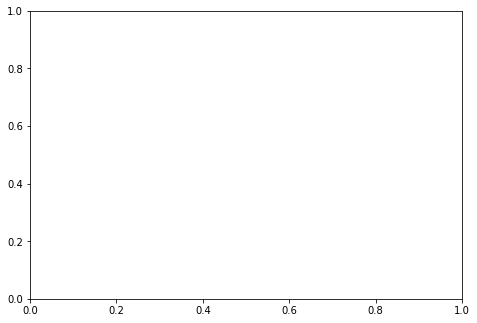

In [18]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"]["show_test_progress"] = show_test_progress
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create some logging dirs if they are not present already
Path(params["ML"]["GAILRunner"]["tf2rl"]["logdir"]).mkdir(exist_ok=True, parents=True)
Path(params["ML"]["GAILRunner"]["tf2rl"]["model_dir"]).mkdir(exist_ok=True, parents=True)

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# load the expert trajectories
expert_trajectories = load_expert_trajectories(
    params["ML"]["GAILRunner"]["tf2rl"]["expert_path_dir"],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env # the unwrapped env has to be used, since that contains the unnormalized spaces.
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

### Trained agent visualization:
Please set up the number of scenarios to visualize in the next cell!

In [4]:
# Number of scenarios to visualize:
num_scenarios_to_visualize = 10

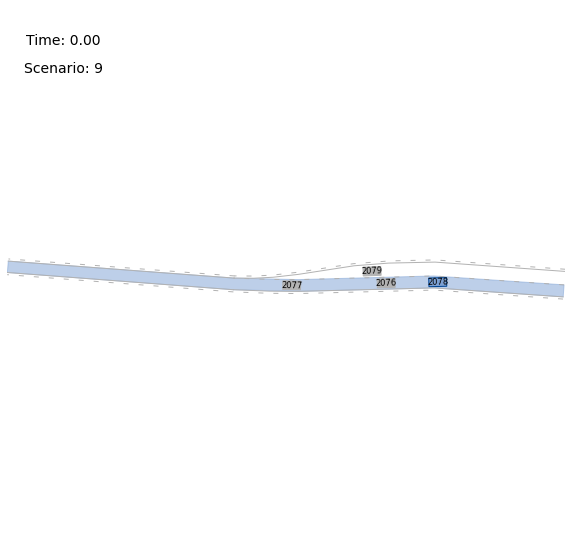

In [5]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = os.path.join('data', 'pretrained_agent')

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"]["show_test_progress"] = show_test_progress
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create some logging dirs if they are not present already
Path(params["ML"]["GAILRunner"]["tf2rl"]["logdir"]).mkdir(exist_ok=True, parents=True)
Path(params["ML"]["GAILRunner"]["tf2rl"]["model_dir"]).mkdir(exist_ok=True, parents=True)

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# load the expert trajectories
expert_trajectories = load_expert_trajectories(
    params["ML"]["GAILRunner"]["tf2rl"]["expert_path_dir"],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env # the unwrapped env has to be used, since that contains the unnormalized spaces.
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")

## Visual results

## Benchmark

## Summary

## Team